# Prédiction de la mortalité avec les données usagers

- Le chargement des données usagers prétraitées
- La préparation
- Le oversampling SMOTE
- L'entraînement et évaluation d'un arbre de décision
---


In [3]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join('..')))

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import numpy as np


### Préparation DataFrame pour prédiction

In [5]:
# Chargement dataset usagers nettoyé
usagers = pd.read_csv("../data/processed/usagers_clean.csv")

# Création variable cible : 1 si grav==2 (mortel), sinon 0
usagers['grav_mortel'] = (usagers['grav'] == 2).astype(int)

# Sélection des colonnes utiles
cols_to_drop = ['Num_Acc', 'id_usager', 'id_vehicule', 'grav', 'actp', 'locp', 'an_nais', 'place']
df = usagers.drop(columns=cols_to_drop)

X = df.drop(columns=['grav_mortel'])
y = df['grav_mortel']

# Séparation train/test avec stratification
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Encodage OneHot sur variables catégoriques
categorical_features = ['secu1', 'sexe', 'catu']
encoder = ColumnTransformer(
    transformers=[('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)],
    remainder='passthrough'
)

X_train_enc = encoder.fit_transform(X_train)
X_test_enc = encoder.transform(X_test)


###  SMOTE pour rééquilibrage ( sur le train uniquement )

In [6]:
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train_enc, y_train)

### Entraînement arbre de décision

In [7]:
clf = DecisionTreeClassifier(max_depth=5, random_state=42)
clf.fit(X_train_res, y_train_res)

DecisionTreeClassifier(max_depth=5, random_state=42)

### Prédiction et évaluation

In [8]:
y_pred = clf.predict(X_test_enc)
print(classification_report(y_test, y_pred))
print("Matrice de confusion :\n", confusion_matrix(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.97      0.66      0.79     17773
           1       0.08      0.60      0.14       855

    accuracy                           0.66     18628
   macro avg       0.53      0.63      0.46     18628
weighted avg       0.93      0.66      0.76     18628

Matrice de confusion :
 [[11796  5977]
 [  342   513]]


### Visualisation arbre (max depth 3 pour lisibilité)

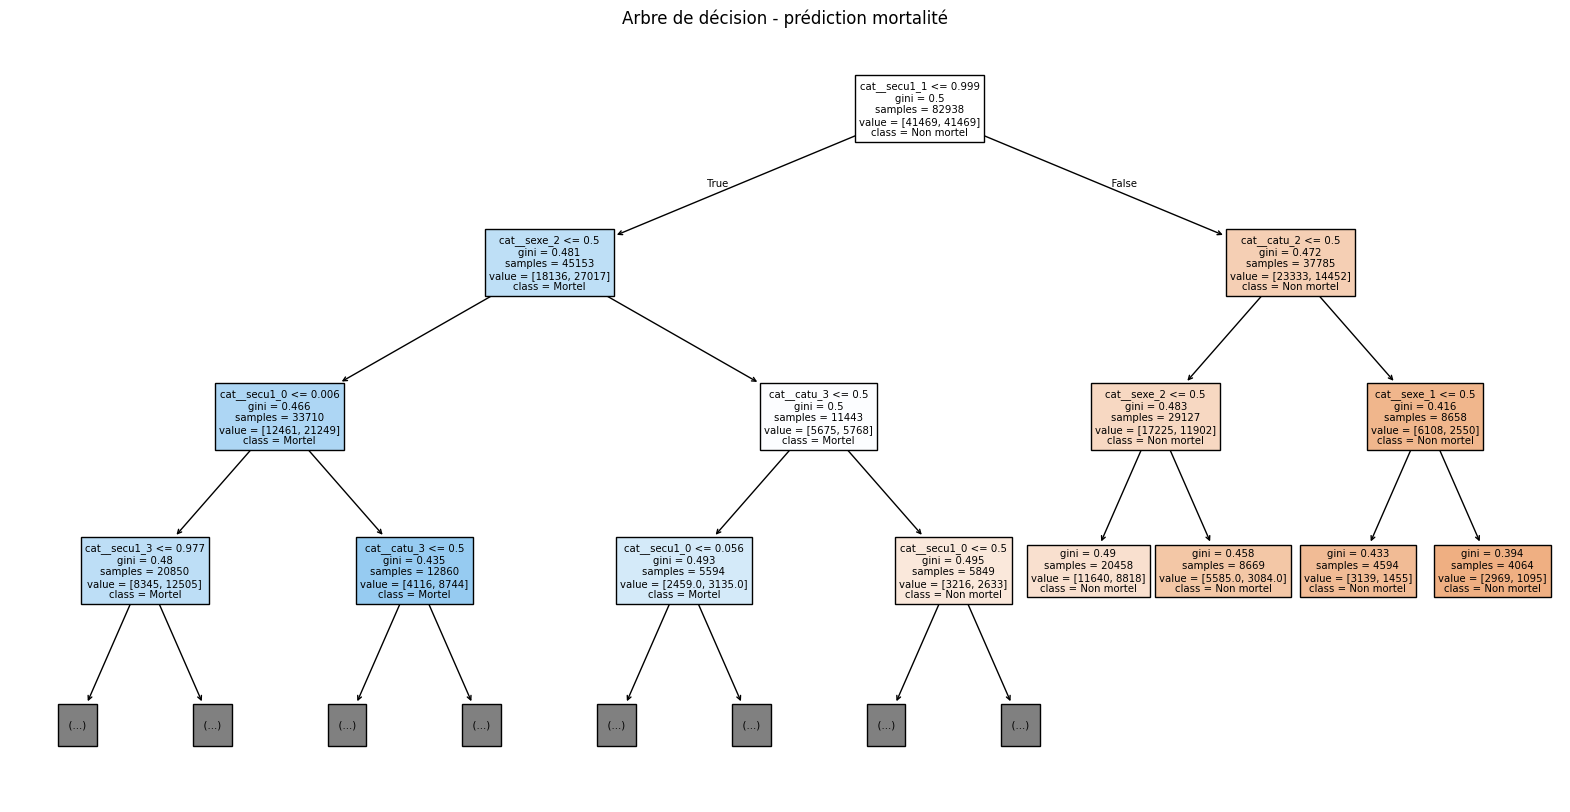

In [9]:
plt.figure(figsize=(20,10))
feature_names = encoder.get_feature_names_out()
plot_tree(clf, feature_names=feature_names, class_names=["Non mortel", "Mortel"], filled=True, max_depth=3)
plt.title("Arbre de décision - prédiction mortalité")
plt.show()

### Importance variables

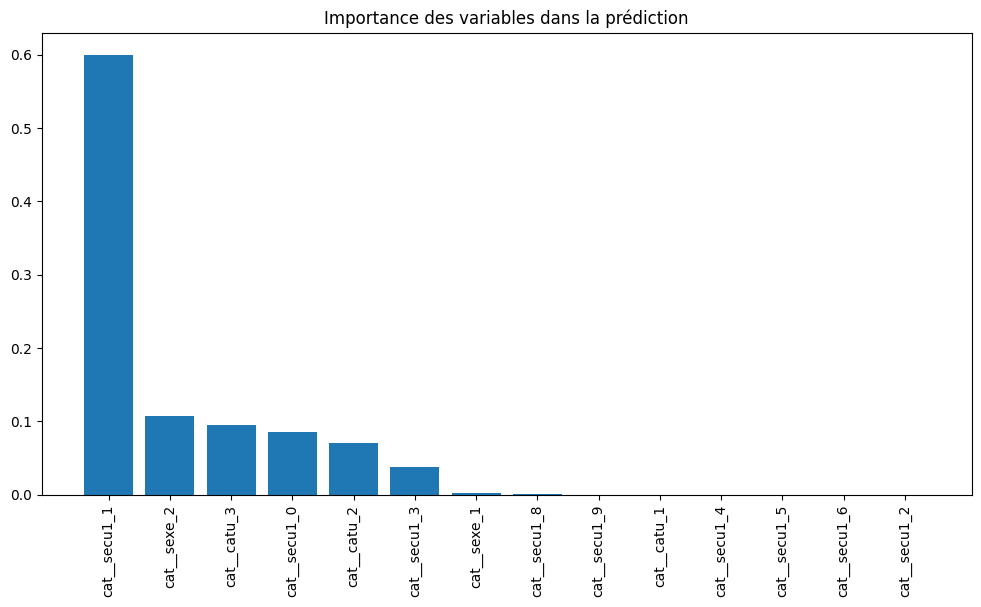

In [10]:
importances = clf.feature_importances_
indices = np.argsort(importances)[::-1]
plt.figure(figsize=(12,6))
plt.bar(range(len(importances)), importances[indices])
plt.xticks(range(len(importances)), feature_names[indices], rotation=90)
plt.title("Importance des variables dans la prédiction")
plt.show()